In [1]:
import os 
from dotenv import load_dotenv
load_dotenv('C:/Users/midon/Documents/anomaly-detection-autoencoder-based-basic/.env.local')
PROJECT_PATH = os.getenv('PROJECT_PATH')
os.chdir(PROJECT_PATH)

import pandas as pd
import numpy as np
from preprocessing.preprocessing import * 
from eval.evaluate_outliers import *
from visualisation import * 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from models.models import BasicAutoencoder

In [14]:
base_path = 'saved_models'
experiment_name = 'BEST_ae_regroup_cat_patience_4'
path = os.path.join(base_path, experiment_name)

if not os.path.exists(path):
    raise FileNotFoundError(f"Experiment path not found: {path}")

model_state = torch.load(os.path.join(path, "weights.pth"))
# model = torch.load(os.path.join(path, "full_model.pth"), weights_only=False)
# with open(os.path.join(path, 'epoch_losses.pkl'), 'rb') as f:
#     epoch_losses = pickle.load(f)
with open('synthetic_data/data/train_test_data.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
        
with open('synthetic_data/data/transformer.pkl', 'rb') as f:
    transformer = pickle.load(f)

with open(os.path.join(path, 'hyperparams.pkl'),'rb') as r:
    hyperparams = pickle.load(r)

X_train_df = loaded_data['X_train']
X_test_df = loaded_data['X_test']
y_train = np.array(loaded_data['y_train'])
y_test = np.array(loaded_data['y_test'])
X_train = transformer.transform_input()
X_test = transformer.transform_input_X(loaded_data['X_test'])
input_dim = X_train.shape[1]
n_binary_cols = len(transformer.get_OHEncoded_cols()) + len(transformer.bool_cols)
attributes_dict = transformer.get_metadata() 

model = BasicAutoencoder(input_dim=input_dim, hidden_dim_1=hyperparams['hidden_dim_1'], hidden_dim_2=hyperparams['hidden_dim_2'], latent_dim=hyperparams['latent_dim'], n_binary_cols = n_binary_cols)
model.load_state_dict(model_state)
model.eval()

BasicAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=20, bias=True)
  )
)

In [9]:
recon_errors_df = get_error_score_new1(model, X_train, attributes_info=attributes_dict, cat_cols=transformer.cat_cols, bool_cols=transformer.bool_cols, X_df = X_train_df)
recon_errors_rows = recon_errors_df.mean(axis = 1)
top_n = len(y_train[y_train == 1])
threshold_value = np.sort(recon_errors_rows)[-top_n]

## Reconstruction error plot

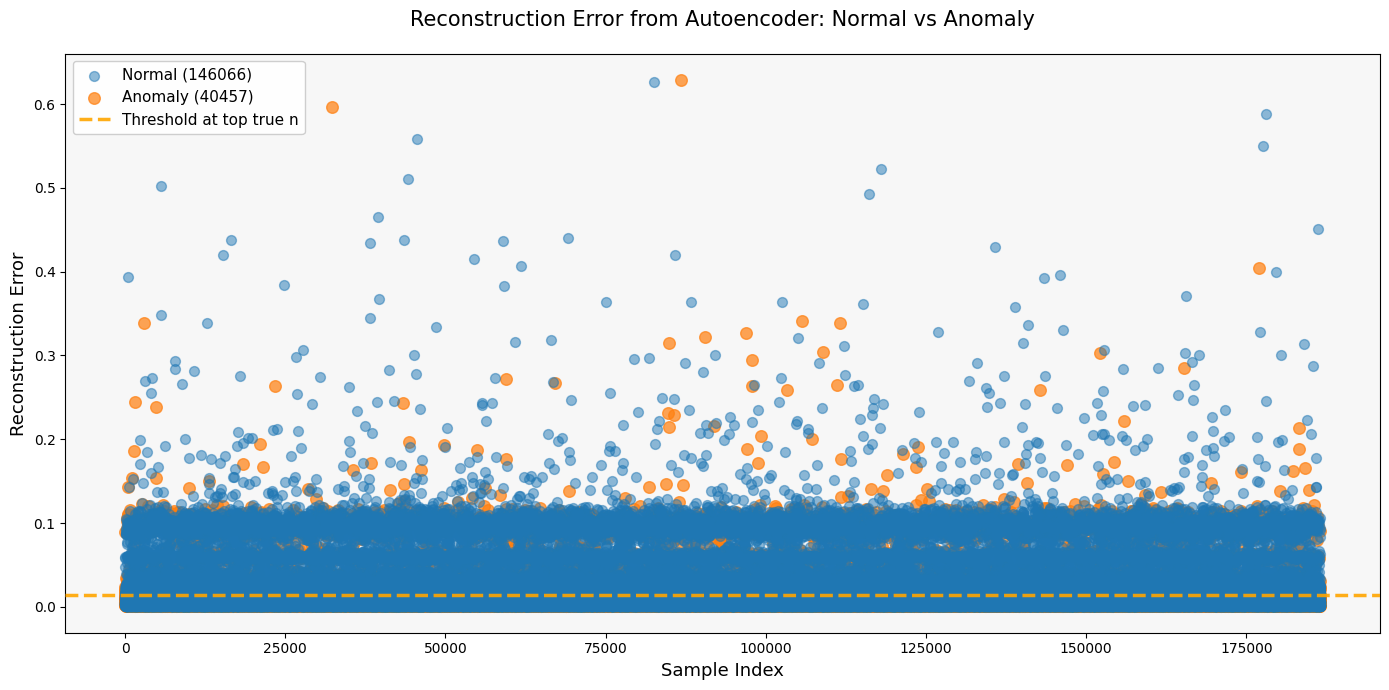

In [ ]:
recon_error_scatter(recon_errors_rows, y_train, threshold_value)

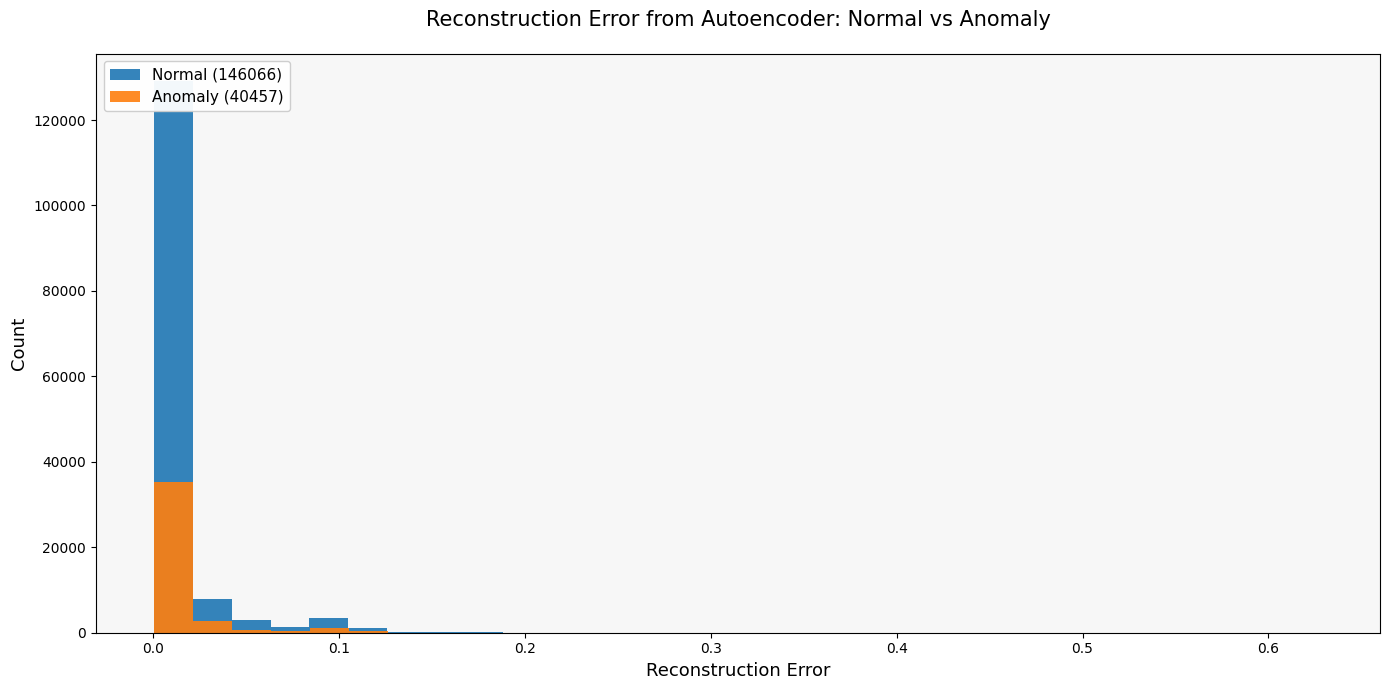

In [24]:
recon_error_hist(recon_errors_rows, y_train)

## Evaluation Metrics

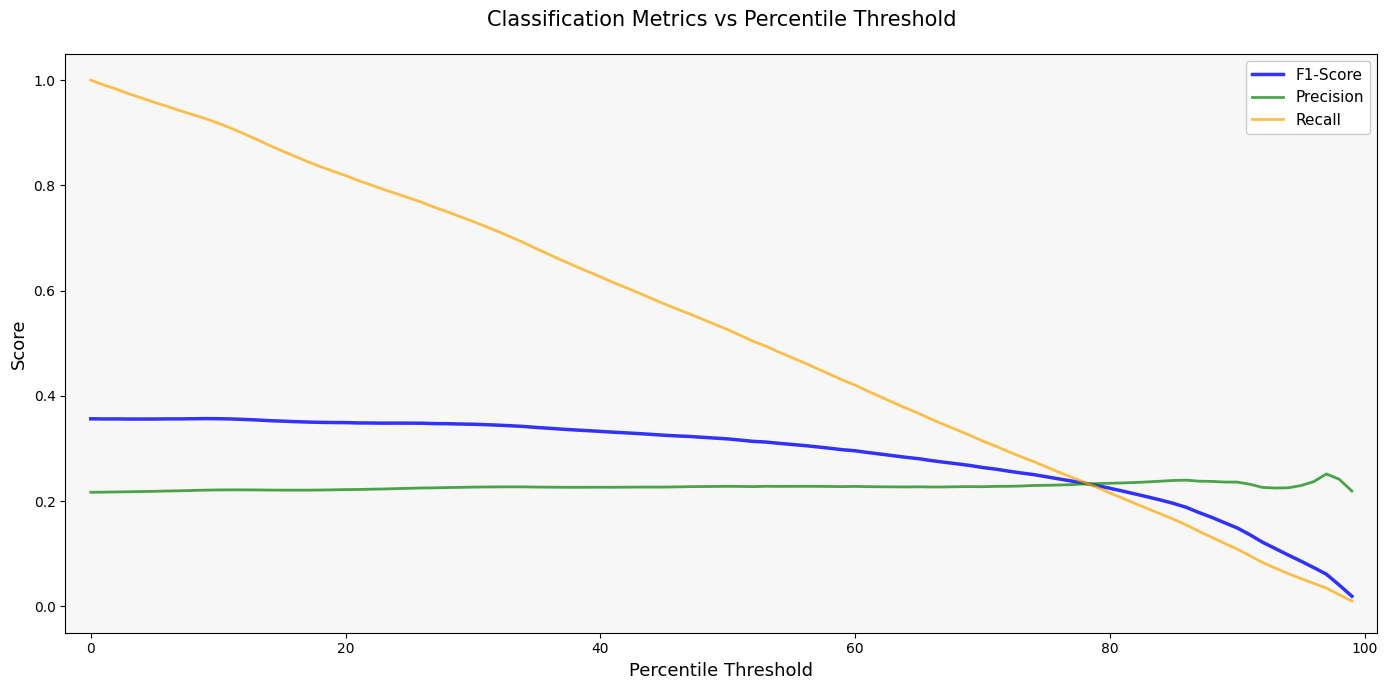

In [25]:
evaluation_metrics_over_percentile_thresholds(recon_errors_rows, y_train)

## Feature importance

In [ ]:
feature_importance = recon_errors_df.mean(axis = 0)
feature_importance_sorted = feature_importance.sort_values()
sorted_index = feature_importance_sorted.index
feature_importance_normal = recon_errors_df[y_train==0].mean(axis=0)
feature_importance_default = recon_errors_df[y_train==1].mean(axis=0)

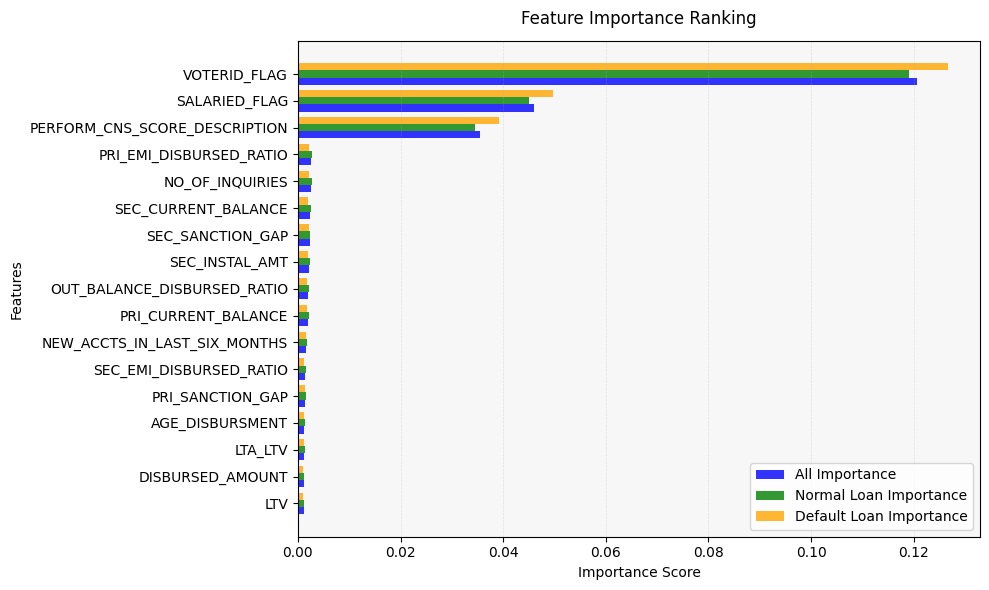

In [15]:
feature_importance_groups_plot(feature_importance, feature_importance_normal, feature_importance_default)

## Reconstruction error on cell-level

In [15]:
recon_X_test = model(torch.from_numpy(X_test))
recon_X_test_df = transformer.transform_preds(recon_X_test.detach().numpy())
recon_X_test_df

,DISBURSED_AMOUNT,LTV,VOTERID_FLAG,PERFORM_CNS_SCORE_DESCRIPTION,PRI_CURRENT_BALANCE,SEC_CURRENT_BALANCE,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,AGE_DISBURSMENT,SALARIED_FLAG,PRI_SANCTION_GAP,SEC_SANCTION_GAP,LTA_LTV,PRI_EMI_DISBURSED_RATIO,SEC_EMI_DISBURSED_RATIO,OUT_BALANCE_DISBURSED_RATIO
0,74577,72.531258,0,High Risk,1158153,-1579,428,1,0,49,0,-2678,569,0.968929,290.935425,0.000000,8.535606
1,48793,73.593964,0,Insufficient / Non-standard Data,-7749,2408,150,0,1,40,0,-1058,-569,0.971868,3539.937744,0.000000,-183.401031
2,57385,79.192352,0,Low Risk,-232817,-16786,0,0,0,42,0,-13149,-989,0.999906,104822.296875,570.543274,-77708.203125
3,44947,63.477631,0,Insufficient / Non-standard Data,48916,861,69,0,0,39,1,2403,94,0.973327,368.162964,0.000000,81.337975
4,50022,73.166588,0,High Risk,19052564,-979,0,2,0,35,0,-265009,146,0.920914,7941.848633,280.977051,499.797089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46626,58298,87.655441,0,Insufficient / Non-standard Data,28516,1651,63,0,0,24,1,151,-146,0.971408,1495.387085,24.048569,-50.458046
46627,47043,66.617783,0,Insufficient / Non-standard Data,14197,1783,37,0,0,53,0,3277,-163,0.975298,0.000000,0.000000,74.141075
46628,59348,57.965427,0,Insufficient / Non-standard Data,-18182,442,0,0,0,20,0,-1064,500,0.958289,950.389893,0.000000,-8.467201
46629,38291,50.368095,1,Insufficient / Non-standard Data,31320,2954,276,0,0,32,0,886,-321,0.975786,977.256592,16.892313,153.105072


Find the largest reconstruction error of true predicted default anomalies

In [16]:
pred_train, pred_test = get_error_score_new_prediction_train_test(X_train, X_test, top_n, model, 
                                                            attributes_info=transformer.get_metadata(), cat_cols = transformer.cat_cols, bool_cols=transformer.bool_cols)
pred_test[y_test==1]

array([0., 0., 0., ..., 0., 1., 0.], shape=(10154,), dtype=float32)

In [21]:
errors_test=get_error_score_new1(model = model, X=X_test, attributes_info=attributes_dict, cat_cols=transformer.cat_cols, bool_cols = transformer.bool_cols, X_df = X_test_df)
errors_test.round(2)

,DISBURSED_AMOUNT,LTV,VOTERID_FLAG,PERFORM_CNS_SCORE_DESCRIPTION,PRI_CURRENT_BALANCE,SEC_CURRENT_BALANCE,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,AGE_DISBURSMENT,SALARIED_FLAG,PRI_SANCTION_GAP,SEC_SANCTION_GAP,LTA_LTV,PRI_EMI_DISBURSED_RATIO,SEC_EMI_DISBURSED_RATIO,OUT_BALANCE_DISBURSED_RATIO
0,0.00,0.0,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,0.00,0.0,0.12,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.0
2,0.06,0.1,0.00,0.01,0.02,0.02,0.04,0.11,0.02,0.00,0.11,0.14,0.36,0.09,0.80,0.01,0.0
3,0.00,0.0,0.18,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.0
4,0.00,0.0,0.00,0.06,0.04,0.02,0.07,0.00,0.03,0.01,0.00,0.01,0.00,0.05,0.01,0.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46626,0.00,0.0,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.0
46627,0.00,0.0,0.12,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.0
46628,0.00,0.0,0.07,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.0
46629,0.00,0.0,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.0


In [20]:
ind_vis = np.argmax(errors_test.mean(axis=1))
pred_test[ind_vis]

np.float32(1.0)

In [30]:
tab = pd.DataFrame([X_test_df.iloc[ind_vis,:],recon_X_test_df.iloc[ind_vis,:]], index=['true value', 'expected value'])
tab

,DISBURSED_AMOUNT,LTV,VOTERID_FLAG,PERFORM_CNS_SCORE_DESCRIPTION,PRI_CURRENT_BALANCE,SEC_CURRENT_BALANCE,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,AGE_DISBURSMENT,SALARIED_FLAG,PRI_SANCTION_GAP,SEC_SANCTION_GAP,LTA_LTV,PRI_EMI_DISBURSED_RATIO,SEC_EMI_DISBURSED_RATIO,OUT_BALANCE_DISBURSED_RATIO
true value,84036,95.0,0,Low Risk,218518,22536122,24242,20,0,18,1,-1691788,137218,1.339922,0.0,0.000911,0.803765
expected value,64222,95.0,0,Insufficient / Non-standard Data,595321,22162066,75525,16,3,18,0,-1605074,116568,1.359349,0.0,0.000000,-11417.290039


C:\Users\midon\AppData\Local\Temp\ipykernel_6316\2865107884.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(error.index, rotation=45, ha='right')


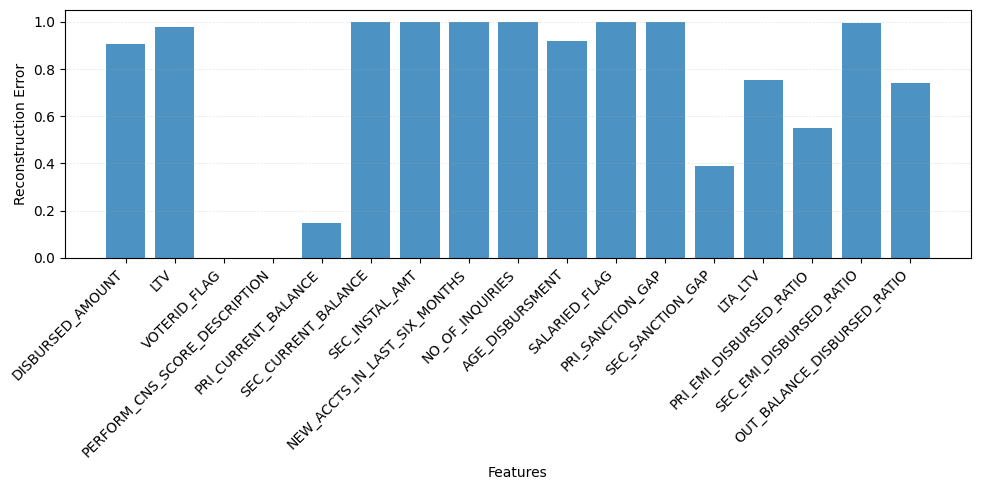

In [39]:
error = errors_test.iloc[ind_vis,:]
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(error.index, error.values, alpha=0.8)
ax.set_ylabel("Reconstruction Error")
ax.set_xlabel("Features")
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, axis='y')
ax.set_xticklabels(error.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()